In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
!pip install funpymodeling
!pip install tensorflow

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils.vis_utils import plot_model
from funpymodeling.exploratory import status, freq_tbl, profiling_num


#https://www.kaggle.com/ronitf/heart-disease-uci
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HeartDesease/heart.csv')

# Exploracion inicial

In [36]:
dataset.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [37]:
dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [38]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


0 age

1 sex 1-male 0-fem

2 cp - chest pain type

3 trestbps resting blood pressure (in mm Hg on admission to the hospital)

4 chol serum cholestoral in mg/dl

5 fbs (fasting blood sugar &gt; 120 mg/dl) (1 = true; 0 = false)

6 restecg resting electrocardiographic results

7 thalach maximum heart rate achieved

8 exang exercise induced angina (1 = yes; 0 = no)

9 oldpeak ST depression induced by exercise relative to rest

10 slope the slope of the peak exercise ST segment

11 ca number of major vessels (0-3) colored by flourosopy

12 thal 3 = normal; 6 = fixed defect; 7 = reversable defect

13 target 1 or 0


In [39]:
status(dataset)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,age,0,0.0,0,0.000000,41,int64
1,sex,0,0.0,96,0.316832,2,int64
2,cp,0,0.0,143,0.471947,4,int64
3,trestbps,0,0.0,0,0.000000,49,int64
4,chol,0,0.0,0,0.000000,152,int64
5,fbs,0,0.0,258,0.851485,2,int64
6,restecg,0,0.0,147,0.485149,3,int64
7,thalach,0,0.0,0,0.000000,91,int64
8,exang,0,0.0,204,0.673267,2,int64
9,oldpeak,0,0.0,99,0.326733,40,float64


In [40]:
nans = dataset[dataset.isna().sum(axis=1)==1]
print(nans.shape)

(0, 14)


Tengo 14 columnas, no hay filas con valores Nans 

In [76]:
categoricas = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
numericas = ['age','trestbps', 'chol', 'thalach', 'oldpeak']

# Variable de salida "Target"

(array([138.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 165.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

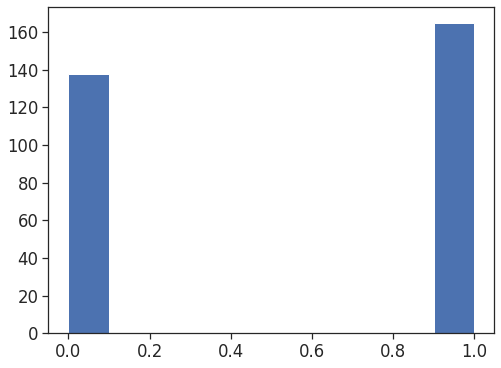

In [41]:
# Analizar la variable de salida
target = dataset.target.to_numpy()
fig, ax = plt.subplots(1,figsize=(8,6))
ax.hist(target)

In [102]:
ds = dataset.copy() #creo una copia del dataset para realizar la ingenieria de features
ds['target'] = ds.target.apply(lambda label: False if (label == 0) else True)
ds.info() # Creo una variable Target de tipo bool

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    bool   
dtypes: bool(1), float64(1), int64(12)
memory usage: 31.2 KB


In [103]:
print(ds[ds['target'] == 0].shape)
print(ds[ds['target'] == 1].shape)

(138, 14)
(165, 14)


# Variables Numericas

In [104]:
def show_boxplot(df, variable):
    fig,axes = plt.subplots(1,len(variable),figsize=(22,8),sharex='row',sharey='row')
    for i, var in enumerate(variable):
        sns.boxplot(y=df[var],ax=axes[i])
        
def show_histogram(dt, var):
    fig = dt.hist(xlabelsize=12, ylabelsize=12,figsize=(22,8), bins=30)
    plt.suptitle(var, fontsize=20)
    [x.title.set_size(14) for x in fig.ravel()]
    plt.tight_layout()
    plt.show()

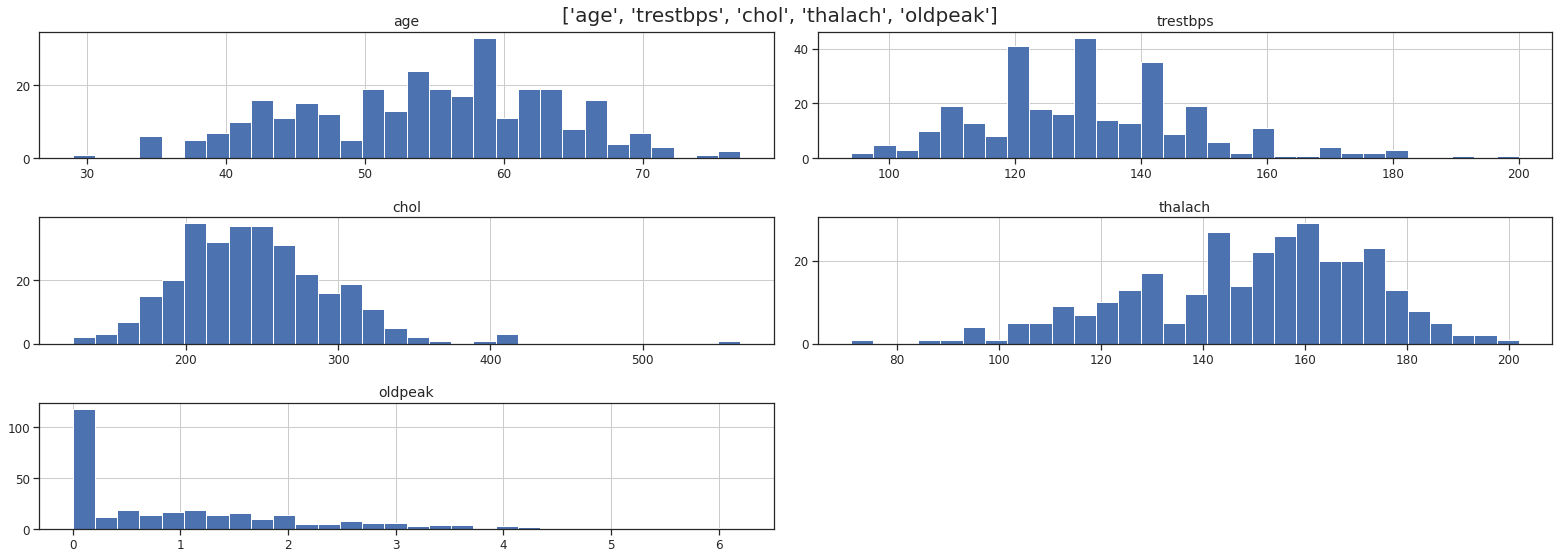

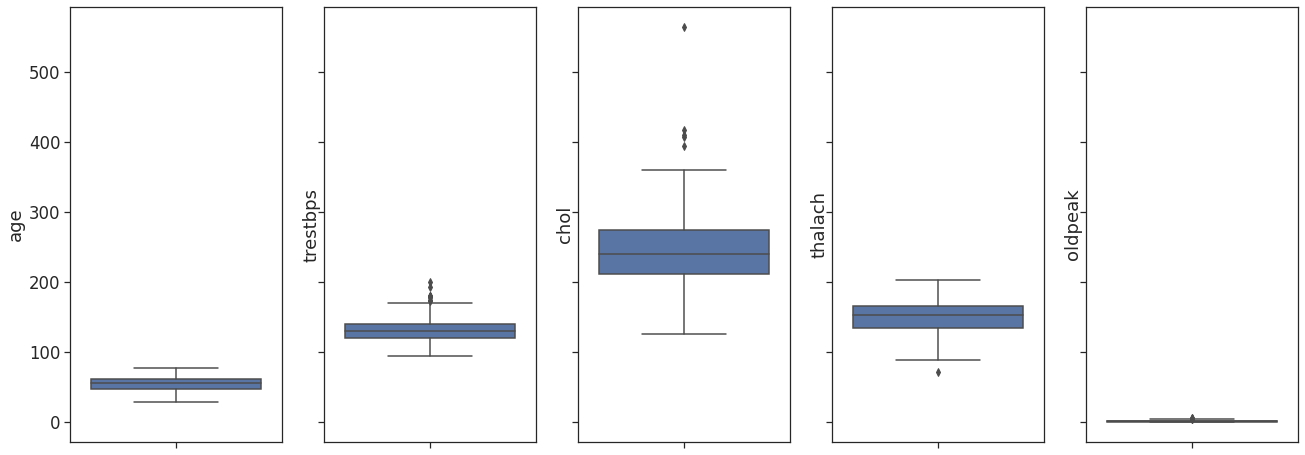

In [105]:
show_histogram(ds[numericas], numericas)
show_boxplot(ds, numericas)

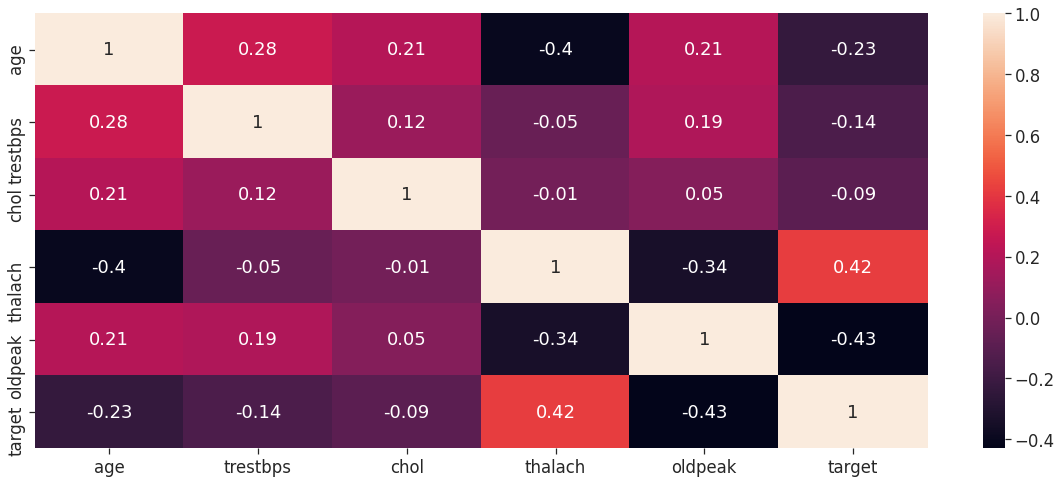

In [106]:
# Matriz de correlación de las variables numericas y variable objetivo, redondeo a 2 decimales
correlation_matrix = ds[['age','trestbps', 'chol', 'thalach', 'oldpeak', 'target']].corr(method='pearson').round(2)
fig,axes = plt.subplots(1,1,figsize=(20,8))
sns.heatmap(data=correlation_matrix, annot=True,ax=axes);

# Variables Categoricas

In [107]:
dataset[categoricas].nunique()

sex        2
cp         4
fbs        2
restecg    3
exang      2
slope      3
ca         5
thal       4
dtype: int64

In [108]:
ds['sex'] = ds.sex.apply(lambda label: False if (label == 0) else True)
ds['fbs'] = ds.sex.apply(lambda label: False if (label == 0) else True)
ds['exang'] = ds.sex.apply(lambda label: False if (label == 0) else True)

In [109]:
ds.info() # Creo una variable Target de tipo bool

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    bool   
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    bool   
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    bool   
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    bool   
dtypes: bool(4), float64(1), int64(9)
memory usage: 25.0 KB


In [110]:
ds[categoricas].head(5)

,sex,cp,fbs,restecg,exang,slope,ca,thal
0,True,3,True,0,True,0,0,1
1,True,2,True,1,True,0,0,2
2,False,1,False,0,False,2,0,2
3,True,1,True,1,True,2,0,2
4,False,0,False,1,False,2,0,2


In [111]:
ds[categoricas].nunique()

sex        2
cp         4
fbs        2
restecg    3
exang      2
slope      3
ca         5
thal       4
dtype: int64

In [112]:
pain = pd.get_dummies(dataset.cp, prefix='pain_type', sparse = True)

In [113]:
pain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype           
---  ------       --------------  -----           
 0   pain_type_0  303 non-null    Sparse[uint8, 0]
 1   pain_type_1  303 non-null    Sparse[uint8, 0]
 2   pain_type_2  303 non-null    Sparse[uint8, 0]
 3   pain_type_3  303 non-null    Sparse[uint8, 0]
dtypes: Sparse[uint8, 0](4)
memory usage: 1.6 KB


In [114]:
ds = pd.concat([ds, pain], axis= 1)

In [115]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype           
---  ------       --------------  -----           
 0   age          303 non-null    int64           
 1   sex          303 non-null    bool            
 2   cp           303 non-null    int64           
 3   trestbps     303 non-null    int64           
 4   chol         303 non-null    int64           
 5   fbs          303 non-null    bool            
 6   restecg      303 non-null    int64           
 7   thalach      303 non-null    int64           
 8   exang        303 non-null    bool            
 9   oldpeak      303 non-null    float64         
 10  slope        303 non-null    int64           
 11  ca           303 non-null    int64           
 12  thal         303 non-null    int64           
 13  target       303 non-null    bool            
 14  pain_type_0  303 non-null    Sparse[uint8, 0]
 15  pain_type_1  303 non-nu